Sources:
 *  [oberlin.edu](http://www2.oberlin.edu/physics/dstyer/QM/Assignments/GaussianWavepacket.pdf)
 *  [Wikipedia](https://en.wikipedia.org/wiki/Wave_packet)

In [1]:
import sympy as sm
import numpy as np
import matplotlib as plt
from IPython.display import display as pprint
sm.init_printing()

Useful Definitions
--------------------
We will be using some definitions from the oberlin paper and some custom ones for this notebook:

$$
\begin{align}
\beta(t) &= 1 + i\frac{\hbar}{m\sigma^2}t\\
E(\vec{p}) &= \frac{\vec{p} \cdot \vec{p}}{2m} \\
\end{align}
$$

General Form of the Wave Packet
-------------------------------
A wave packet is an equation of a wave trapped within a certain "width" $\sigma$ travelling with a certain "speed" $\frac{p_0}{m}$. 

From oberlin, this wave has an equation of the form:
$$
\begin{equation}
\Psi(\vec{x}, t) = \frac{1}{\sqrt{\sigma \beta \sqrt{\pi}}}
\exp{\left(\frac{i}{\hbar}(\vec{p_0} \cdot \vec{x} - E(\vec{p_0})t)\right)}
\exp{\left(-\frac{1}{2\sigma^2\beta}(\vec{x} - \frac{\vec{p_0}}{m}t)^2\right)}
\end{equation}
$$

However, it is actually more useful to start with the $\Psi(\vec{x},0)$ wave function:
$$
\begin{equation}
\Psi(\vec{x}, 0) = \frac{1}{\sqrt{\sigma \sqrt{\pi}}}
\exp{\left(\frac{i}{\hbar}(\vec{p_0} \cdot \vec{x})\right)}
\exp{\left(-\frac{1}{2\sigma^2}(\vec{x})^2\right)}
\end{equation}
$$
since then we can generate the time steps on the fly via the Schrodinger Equation:
$$
i\hbar\frac{\partial \Psi}{\partial t} = V(\vec{x}, t)\Psi - \frac{\hbar^2}{2m}\nabla^2\Psi
$$

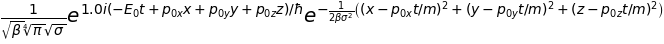

In [2]:
#Constants 
sigma, hbar, pi,m = sm.symbols('\sigma, \hbar, \pi, m', positive=True, real=True)

#Initial momentum
p_0 = sm.Matrix([*sm.symbols('p_{0x}, p_{0y}, p_{0z}')])

#Time, distance param; r = sqrt(x_v.dot(x_v))
r = sm.Symbol('|\\vec{x}|', real=True, positive=True)
t = sm.Symbol('t', real=True, positive=True)


#Position parameters
x_v = sm.Matrix([*sm.symbols('x, y, z')])
x, y, z = x_v

#Just for ease of visualisation
PX = sm.Symbol("(\\vec{p_0} \\cdot \\vec{x})")

#Oberlin vars
E_0 = sm.symbols('E_0', positive=True, real=True) #p_0.dot(p_0)/2*m
B = sm.symbols('\\beta')#1 + 1j*hbar*t/(m * sigma^2)

#Potential function
V = sm.symbols('V')

#Split up the declarations for legibility
Psi_coeff = 1/sm.sqrt(sigma * B * sm.sqrt(pi))
Psi_evo = sm.exp(1j/hbar * (p_0.dot(x_v) -E_0 * t))
Psi_pkt = sm.exp(-1/(2 * sigma**2 * B) * (x_v - p_0/m * t).dot(x_v - p_0/m * t))

#Build Psi
Psi = Psi_coeff * Psi_evo * Psi_pkt
Psi_t0 = Psi.subs({B : 1 + 1j*hbar *t/(m * sigma**2), t : 0}).simplify()
pprint(Psi)
pprint(Psi_t0)

These are some useful functions to make equations more legible:

In [3]:
def e_rep(elm):
    relm = elm#.expand()
    
    #E_0 replacement
    epart_trms = [term for term in relm.args if term.has(p_0[0]**2) or term.has(p_0[1]**2) or term.has(p_0[2]**2)]
    if len(epart_trms) == 0:
        return relm
    nepart_trms = [term for term in relm.args if not term in epart_trms]
    epart = sum(epart_trms).factor() \
        .subs({1.0 * p_0.dot(p_0) : E_0 * 2 * m}) \
        .subs({p_0.dot(p_0) : E_0 * 2 * m})
    relm = (epart + sum(nepart_trms)).expand()
    return relm

def r_rep(elm):
    relm = elm.expand()

    #r**2 replacement
    xpart_trms = [term for term in relm.args if term.has(x**2) or term.has(y**2) or term.has(z**2)]
    if len(xpart_trms) == 0:
        return relm
    nxpart_trms = [term for term in relm.args if not term in xpart_trms]
    xpart = sum(xpart_trms).factor() \
        .subs({ x_v.dot(x_v) : r**2}) \
        .subs({ 1.0 * x_v.dot(x_v) : r**2})
    relm = (xpart + sum(nxpart_trms)).expand()
    return relm

def px_rep(elm):
    relm = elm.expand()

    
    #PX replacement
    pxpart_trms = [term for term in relm.args if term.has(x*p_0[0]) or term.has(y*p_0[1]) or term.has(z*p_0[2])]
    if len(pxpart_trms) == 0:
        return relm
    npxpart_trms = [term for term in relm.args if not term in pxpart_trms]
    pxpart = sum(pxpart_trms).factor() \
        .subs({1.0 * p_0.dot(x_v) : PX}) \
        .subs({p_0.dot(x_v) : PX})

    relm = (pxpart + sum(npxpart_trms)).expand()
    
    return relm
def b_rep(elm):
    return elm.subs({B : 1 + (1j*hbar*t)/(m * sigma**2)})

def red_exp(elm):
    return b_rep(px_rep(r_rep(e_rep(elm))))


Next we build the $t=0$ Laplacian and $KE_{coeff}$ functions to have a good starting point:

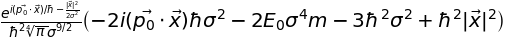

In [4]:
lap_t0 = (Psi_t0.diff(x, 2) + Psi_t0.diff(y, 2) + Psi_t0.diff(z, 2)) \
    .subs({x_v.dot(x_v) : r**2, x_v.dot(p_0) : PX, }) \
    .expand()
lap_t0 = red_exp(lap_t0).nsimplify().simplify()
lap_t0

Hamiltonian Estimation
----------------------------------
Now that we have the wave at $t=0$, we need to evolve it via the Schrodinger Equation. To do that, we will
create equations to numerically estimate $\Psi(\vec{x}, t+ s)$ from the wave function at time $t$. 

First, we will estimate the Hamiltonian of $\Psi$ at constant $t$:

The Taylor expansion for a function $g(a)$ is 

$$g(a + \Delta a) = \sum_{k = 0}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a)$$

.

Using this a formula can be extracted to determine the $n$th derivative of the function:

$$\begin{align}
g(a + \Delta a) &= \sum_{k = 0}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) 
\\
&= \sum_{k = 0}^{n - 1} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) + 
\frac{(\Delta a)^n}{n!} \frac{d^n g}{da^n}(a) +
\sum_{k = n + 1}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) 
\\
g(a + \Delta a) - \sum_{k = 0}^{n - 1} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) - \sum_{k = n + 1}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) &= \frac{(\Delta a)^n}{n!} \frac{d^n g}{da^n}(a)
\\
\frac{n!}{(\Delta a)^n}\left(
g(a + \Delta a) - \sum_{k = 0}^{n - 1} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) - \sum_{k = n + 1}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a)
\right)
&= \frac{d^n g}{da^n}(a)
\end{align}$$


A similar formula can be generated by replacing $\Delta a$ with $- \Delta a$:

$$\begin{align}
g(a - \Delta a) &= \sum_{k = 0}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) 
\\
&= \sum_{k = 0}^{n - 1} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) + 
\frac{(-\Delta a)^n}{n!} \frac{d^n g}{da^n}(a) +
\sum_{k = n + 1}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) 
\\
g(a - \Delta a) - \sum_{k = 0}^{n - 1} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) - \sum_{k = n + 1}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) &= \frac{(-\Delta a)^n}{n!} \frac{d^n g}{da^n}(a)
\\
\frac{n!}{(-\Delta a)^n}\left(
g(a - \Delta a) - \sum_{k = 0}^{n - 1} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) - \sum_{k = n + 1}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a)
\right)
&= \frac{d^n g}{da^n}(a)
\end{align}$$

This is useful because, depending on $n$, they can be combined into a more accurate result. We only care about the cases $n=1$ and $n=2$ though, for the components of the Schrodinger equation. For $n=2$:

$$\begin{align}
g(a + \Delta a) &= \sum_{k = 0}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) 
\\
&= g(a) + 
\Delta a \frac{d g}{da}(a) +
\frac{(\Delta a)^2}{2} \frac{d^2 g}{da^2}(a) +
\sum_{k = 3}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) 
\\
g(a + \Delta a) - g(a) - \Delta a \frac{d g}{da}(a) - \sum_{k = 3}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) &= \frac{(\Delta a)^2}{2} \frac{d^2 g}{da^2}(a)
\\
\frac{2}{(\Delta a)^2}\left(
g(a + \Delta a) - g(a) - \Delta a \frac{d g}{da}(a) - \sum_{k = 3}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a)
\right)
&= \frac{d^2 g}{da^2}(a)
\end{align}$$




$$\begin{align}
g(a - \Delta a) &= \sum_{k = 0}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) 
\\
&= g(a) -
\Delta a \frac{d g}{da}(a) +
\frac{(\Delta a)^2}{2} \frac{d^2 g}{da^2}(a) +
\sum_{k = 3}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) 
\\
g(a - \Delta a) - g(a) + \Delta a \frac{d g}{da}(a) - \sum_{k = 3}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a) &= \frac{(\Delta a)^2}{2} \frac{d^2 g}{da^2}(a)
\\
\frac{2}{(\Delta a)^2}\left(
g(a - \Delta a) - g(a) + \Delta a \frac{d g}{da}(a) - \sum_{k = 3}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a)
\right)
&= \frac{d^2 g}{da^2}(a)
\end{align}$$

Add the 2 equations:

$$\begin{align}
2 \frac{d^2 g}{da^2}(a) &= 
\frac{2}{(\Delta a)^2}\left(
g(a - \Delta a) - g(a) + \Delta a \frac{d g}{da}(a) - \sum_{k = 3}^{\infty} \frac{(-\Delta a)^k}{k!} \frac{d^k g}{da^k}(a)
+
g(a + \Delta a) - g(a) - \Delta a \frac{d g}{da}(a) - \sum_{k = 3}^{\infty} \frac{(\Delta a)^k}{k!} \frac{d^k g}{da^k}(a)
\right)
\\
 \frac{d^2 g}{da^2}(a) &= 
\frac{1}{(\Delta a)^2}\left(
g(a - \Delta a) + g(a + \Delta a)  - 2g(a)  - \sum_{k = 1}^{\infty} \frac{2(\Delta a)^{2k+1}}{(2k+1)!} \frac{d^{2k+1}g}{da^{2k+1}}(a)
\right)
\end{align}$$

We can then use this to estimate the laplacian of $\Psi$, using a constant step value $d$:

$$\begin{align}
\nabla^2\Psi(\vec{a}, t) &= \sum_{j=0}^{Dims} \frac{\partial^2 \Psi}{\partial x_j^2} \\
&\approx \sum_j \frac{1}{d^2} \left(
\Psi(\vec{a} + d{\vec{x_j}}, t) + \Psi(\vec{a} - d{\vec{x_j}}, t) - 2\Psi(\vec{a}, t)
\right)
\\
&= \frac{-2D}{d^2}\Psi(\vec{a}, t) + \frac{1}{d^2} \sum_j  \left(
\Psi(\vec{a} + d{\vec{x_j}}, t) + \Psi(\vec{a} - d{\vec{x_j}}, t) 
\right)
\end{align}$$

Finally we construct our estimation for $\hat{H}\Psi$:

$$\begin{align}
\hat{H}\Psi(\vec{x}, t) &= -\frac{\hbar^2}{2m}\nabla^2\Psi(\vec{x}, t) + V\Psi(\vec{x}, t) \\
&= \left(V(\vec{x}, t) + \frac{D\hbar^2}{md^2}\right)\Psi(\vec{x}, t) - \frac{\hbar^2}{2md^2}\sum_j \left(\Psi(\vec{x} + d\vec{x}_j, t) + \Psi(\vec{x} - d\vec{x}_j, t)\right)
\end{align}$$

Time Step Estimation
--------------------------
Next we will find an estimate for the time evolution, $\Psi(\vec{x}, t + s)$. 

The partial Taylor expation of $\Psi$ for $t$ is 

$$
\Psi(\vec{x}, t + s) =  \sum_{k = 0}^{\infty} \frac{s^k}{k!} \frac{\partial^k \Psi}{\partial a^k}(\vec{x}, t)
$$

Since we already know that $\frac{\partial \Psi}{\partial t}(\vec{x}, t) = \frac{\hat{H}\Psi(\vec{x}, t)}{i\hbar}$, we can expand the first 2 terms:

$$\begin{align}
\Psi(\vec{x}, t + s) &=  \sum_{k = 0}^{\infty} \frac{s^k}{k!} \frac{\partial^k \Psi}{\partial t^k}(\vec{x}, t) \\
&=  \Psi(\vec{x}, t) + s\frac{\partial \Psi}{\partial t}(\vec{x}, t) + \sum_{k = 2}^{\infty} \frac{s^k}{k!} \frac{\partial^k \Psi}{\partial t^k}(\vec{x}, t) \\
\end{align}$$

We again flip the step variable to reduce the error:

$$\begin{align}
\Psi(\vec{x}, t - s) &=  \sum_{k = 0}^{\infty} \frac{(-s)^k}{k!} \frac{\partial^k \Psi}{\partial t^k}(\vec{x}, t) 
\\
&=  \Psi(\vec{x}, t) - s\frac{\partial \Psi}{\partial t}(\vec{x}, t) + \sum_{k = 2}^{\infty} \frac{(-s)^k}{k!} \frac{\partial^k \Psi}{\partial t^k}(\vec{x}, t) 
\\
\end{align}$$

Combining the 2 produces:

$$
\Psi(\vec{x}, t+s) = \Psi(\vec{x}, t - s) + 2s\frac{\partial \Psi}{\partial t}(\vec{x}, t) + \sum_{k = 1}^\infty \frac{2s^{2k+1}}{(2k+1)!} \frac{\partial ^{2k+1}\Psi}{\partial t^{2k+1}}(\vec{x}, t) 
\\
\approx \Psi(\vec{x}, t - s) + 2s\frac{\partial \Psi}{\partial t}(\vec{x}, t)
$$

Final Equation
----------------
Finally we can combine everything into a single equation:

$\Psi(\vec{x}, t+s) = \Psi(\vec{x}, t - s) + \frac{2s}{i\hbar}\left(
(V(\vec{x}, t) + \frac{D\hbar^2}{md^2})\Psi(\vec{x}, t) - \frac{\hbar^2}{2md^2}\sum_j \left(\Psi(\vec{x} + d\vec{x}_j, t) + \Psi(\vec{x} - d\vec{x}_j, t)\right)
\right)$

Example Calculations
------------------------
We will exclusively be performing the simulations in a 2-D environment so we can use a colormap.

We will also construct an object to hold and run simulations using our new equations:

In [131]:
class ExperimentRunner(object):
    
    """Constructs a new experiment holder. 
    V is a potential function of type (x, y, t) -> double.
    m is the mass.
    d is the position step value.
    s is the time step value.
    xmin/xmax/ymin/ymax specify the rectangular borders.
    hbar is the value we will use to estimate the reduced Planck constant.
    res is a pre-loaded results board."""
    def __init__(self, V, m, d, s, xmin, xmax, ymin, ymax, hbar, res):
        self.V = V
        self.d = d
        self.s = s
        self.res = res
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.boundschecks = {}
        
        self.Hcoeff = 2*s/(1j * hbar)
        self.lap_Psi_coeff = hbar**2/(m * d**2)
        self.lap_offPsi_coeff = -hbar**2/(2 * m * d**2)
        assert self.Hcoeff != 0
        assert self.lap_Psi_coeff != 0
        assert self.lap_offPsi_coeff != 0


    
    """Gets a previous Psi result. The numbers passed are in index form for speed."""
    def getPsiRes(self, xind, yind, tind):
        if xind < 0 or xind + 1 > len(self.res[0]) or yind < 0 or yind + 1 > len(self.res[0][0]) and not '{} | {} | {}'.format(tind, xind, yind) in self.boundschecks:
            self.boundschecks['{} | {} | {}'.format(tind, xind, yind)] = 'getRes;'
            return 0
        assert tind <= len(self.res), "Can't just predict from nothing!"
        if tind < 0:
            tind = 0
        return self.res[tind][xind][yind]
    
    """Calculates the value of Psi(x, y, ts) from previous results."""
    def calcNextPsi(self, args):
        
        x, y, ts = args
        
        #Current t
        t = ts - self.s
        
        #Border conditions 
        if x > self.xmax or x < self.xmin or y > self.ymax or y < self.ymin and not '{} | {} | {}'.format(tind, xind, yind) in self.boundschecks:
            self.boundschecks['{} | {} | {}'.format(tind, xind, yind)] = 'calcNext;'
            return 0
                        
        #Get the indices in the results list
        tind = int(round(t/self.s))
        xind = int(round((x - self.xmin)/self.d))
        yind = int(round((y - self.ymin)/self.d))
                
        #Err if we didn't yet make a new res board
        assert len(self.res) -1 >= tind+1, "Results dimension err: wanted {} but got {}!\nRes is:\n{}".format(tind + 1, len(self.res)-1, str(self.res))
                
        #Err if we already calced here
        assert self.res[tind+1][xind][yind] == 0, "Already calced at {}, {}, {}!" %(tind+1, xind, yind)
        
        
        #Psi here, now
        Psi_t = self.getPsiRes(xind, yind, tind)
        #Psi here, before
        Psi_t_s = self.getPsiRes(xind, yind, tind - 1)
        #Psi to the +x
        Psi_xs = self.getPsiRes(xind+1, yind, tind)
        #Psi to the -x
        Psi_x_s = self.getPsiRes(xind-1, yind, tind)
        #Psi to the +y
        Psi_ys = self.getPsiRes(xind, yind+1, tind)
        #Psi to the -y
        Psi_y_s = self.getPsiRes(xind, yind-1, tind)
        
        #The sum of the positional offsets
        offPsi = Psi_xs + Psi_x_s + Psi_ys + Psi_y_s
        
        if not offPsi and not '{} | {} | {}'.format(tind, xind, yind) in self.boundschecks:
            self.boundschecks['{} | {} | {}'.format(tind, xind, yind)] = 'offPsi;'

        
        #The current hamiltonian
        HPsi = (self.V(x, y, t) + self.lap_Psi_coeff) * Psi_t + self.lap_offPsi_coeff * offPsi
        
        if not HPsi and not '{} | {} | {}'.format(tind, xind, yind) in self.boundschecks:
            self.boundschecks['{} | {} | {}'.format(tind, xind, yind)] = 'HPsi;'
        
        Psi_ts = Psi_t_s + self.Hcoeff * HPsi
        
        if not Psi_ts and not '{} | {} | {}'.format(tind, xind, yind) in self.boundschecks:
            self.boundschecks['{} | {} | {}'.format(tind, xind, yind)] = 'Sum;'

        
        
        self.res[tind + 1][xind][yind] = Psi_ts
        
        if not self.res[tind + 1][xind][yind]:
            print(self.boundschecks)
            assert False, "Fuck"
        return Psi_ts
    
    """Constructs and adds an empty results board to self.res."""
    def makeBoard(self):
        startlen = len(self.res)
        xdim = int(round((self.xmax - self.xmin)/self.d))
        ydim = int(round((self.ymax - self.ymin)/self.d))
        self.res.append(np.zeros((xdim, ydim), dtype=complex))
        assert len(self.res) == startlen + 1
    

For our example potential, we will construct a square container from -1 to 1 on each side with a potential "dome" of the form $V(x, y, t) = -\sqrt{x^2 + y^2}$:

In [132]:
def V_f(x, y, t):
    if x >= 1 or x <= -1 or y >= 1 or y <= -1:
        return 9e99
    r = np.sqrt(x**2 + y**2)
    if r <= 1:
        return r
    else:
        return 0

Instead of starting with a wave packet, we will use a Dirac delta wave at $t=0$ and $d=s=10^{-3}$:

In [133]:
ymin = xmin = -1
ymax = xmax = 1
d_v = 10**-3
s_v = 10**-3
res0 = [np.zeros((2000, 2000), dtype=complex)]
res0[0][1000][1000] = 1.0 + 0j

In [134]:
exp1_runner = ExperimentRunner(V_f, 1, d_v, s_v, xmin, xmax, ymin, ymax, 1, res=res0)
len(exp1_runner.res)

In [136]:
import multiprocessing as parl

threads = parl.Pool(processes=1)

for tind in range(1, 10):
    exp1_runner.makeBoard()
    for xind in range(0, 2000):
        curArgs = map(lambda yind: (xind * d_v + xmin, yind * d_v + ymin, s_v * tind), range(0, 2000))
        threads.map(ewxp1_runner.calcNextPsi, curArgs)
        assert np.any(exp1_runner.res[tind]), "Wave disappeared at index "+str(tind)
    print('Finished calcing for tind '+str(tind))


{'0 | -1 | 0': 'getRes;', '0 | 0 | -1': 'getRes;', '0 | 0 | 0': 'offPsi;'}
{'0 | -1 | 500': 'getRes;', '0 | 0 | 500': 'offPsi;'}
{'0 | -1 | 1000': 'getRes;', '0 | 0 | 1000': 'offPsi;'}
{'0 | -1 | 1500': 'getRes;', '0 | 0 | 1500': 'offPsi;'}


AssertionError: Fuck